In [ ]:
!pip install tqdm

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import lognorm
%matplotlib inline

from tqdm.notebook import tqdm

if not Path('bank-marketing-data.csv').exists():
    !wget https://s3-eu-west-1.amazonaws.com/faculty-client-teaching-materials/computational-statistics/bank-marketing-data.csv

# Results summary

Based on a sample of size 5,000 - values are approximate.

The below table contains a summary of the (approximate) answers.

| Metric | Sample value | Asymptotic SE | Std dev of pop sampling dist | Std dev from BS | Std dev from parametric BS*
| --- | :---: | :---: | :---: | :---: | :---: |
| Mean | 256 | 3.63 | 3.66 | 3.59 | 4.38 |
| Median | 176.5 | 2.61 (fit kde)* | 2.65 | 2.69 | 2.87 |
| Trimmed mean | 224 | 2.33 (use trimmed data) | 3.04 | 3.05 | 3.21 |

\*indicates optional/extra content.

# 0. Contents

1. [Introduction](#1)
2. [Data](#2)
    1. [Load data](#2.1)
    2. [Problem: duration of the average call](#2.2)
3. [Bootstrapping](#3)
    1. [Implementing bootstrap sampling](#3.1)
    2. [Bootstrap Standard Errors](#3.2)
4. [Parametric bootstrapping](#4)
5. [Classical approach](#5)
    1. [Estimate call duration](#5.1)
    2. [Standard errors](#5.2)
    3. [Thoughts on asymptotics](#5.3)

### Summary of exercises

1. [Bootstrap sample](#bootstrap_sample)
2. [Bootstrap sampling](#bootstrap_sampling)
3. [Efficient bootstrap sampling](#eff_bootstrap_sampling)
4. [Bootstrapping to obtain standard errors](#bootstrap_se)
5. [Parametric bootstrapping](#parametric_bootstrapping)
6. [Estimate call duration](#calc_stats)
7. [Standard deviation of the sampling distribution of the mean](#mean_se)
8. [Computational estimates of standard error for median and trimmed mean](#tr_mean_med_se)
9. [Alternative approach for standard error of trimmed mean](#trim_mean_se)
10. [Asymptotic formula for standard error of median](#asym_median)

# 1. Introduction <a id="1"></a>

We are going to look at how long people spend on the phone. We will treat `df["duration"]` as though it were the true population distribution whilst only having access to a subset of this information, i.e. a sample from the true population distribution.

**Goal** 

1. Obtain estimates for the duration of the average call, considering 3 different statistics for our notion of 'average call': 
    * mean
    * trimmed mean
    * median

2. Understand how precise we can expect our estimates to be (that is, how much they might differ from the 'true' value of the statistic obtained when computed using the entire population). We will do this by estimating properties of their sampling distributions.

# 2. Data <a id="2"></a>

### 2.1 Load data <a id="2.1"></a>

This is a dataset of information to do with telephone marketing campaigns by a Portuguese bank, documented [here](https://archive.ics.uci.edu/ml/datasets/bank+marketing).

<sup>Dataset: [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014</sup>

In [2]:
df = pd.read_csv("bank-marketing-data.csv", sep=";")

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


So how long do people spend on the phone, typically?

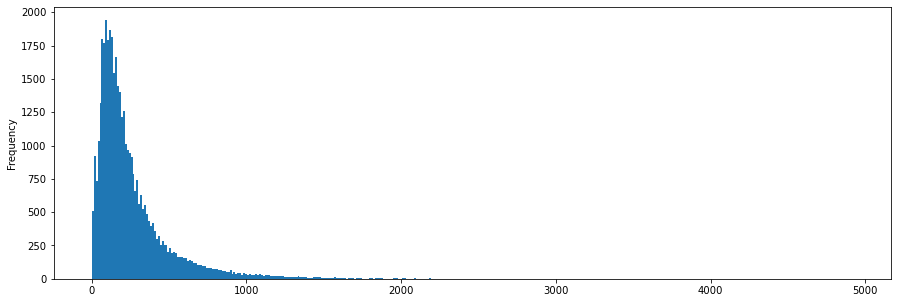

In [4]:
df["duration"].plot.hist(bins="fd", figsize=(15, 5));

### 2.2 Problem: duration of the average call <a id="2.2"></a>

* Imagine that we are only given a sample of 5000 points from this distribution of call times (say, the call durations from just one call centre), and our task is to obtain an estimate for the duration of the average call which is relatively precise. As discussed above, we'll examine using three different statistics for this purpose: the mean, the trimmed mean, and the median.
* To work out which of these three statistics has the smallest error on our dataset, we'll need to find ways of estimating properties of their **sampling distributions**. Namely, the standard deviation/error of these distributions, and their percentiles (in order to build confidence intervals).
* Another motivation for considering both the median and trimmed mean as well as just the mean is that what we're really interested in is the **duration of the average call** rather than the **average call duration** - we want to be wary of the effect of outliers in our analysis.

Before we start we can calculate what the sampling distribution from the population looks like by repeating sampling from `df['duration']`.

In [11]:
def trimmed_mean(arr):
    low, high = np.percentile(arr, [5, 95])
    return arr[np.logical_and(arr < high, arr > low)].mean()


def repeated_samples(arr, n_samples, sample_size, statistic):
    samples = np.random.choice(arr, n_samples * sample_size)
    sub_samples = samples.reshape(n_samples, sample_size)
    return np.apply_along_axis(statistic, 1, sub_samples)

In [12]:
statistics = [np.mean, trimmed_mean, np.median]

In [13]:
true_stds = {
    statistic.__name__: repeated_samples(df["duration"], 10_000, 5_000, statistic).std()
    for statistic in statistics
}

In [14]:
print("True sampling distribution standard deviations:")
for name, std in true_stds.items():
    print(f"{name}: {std:.2f}")

True sampling distribution standard deviations:
mean: 3.69
trimmed_mean: 3.04
median: 2.68


We now have one column of the results summary table above. Let's take a look at the bootstrap in comparison. Before we start to look at the bootstrap, let's get a sample of data.

In [15]:
sample = np.array(df["duration"].sample(5000, random_state=16))

# 3. Bootstrapping <a id="3"></a>

### 3.1. Implementing bootstrap sampling <a id="3.1"></a>

#### Exercise 1: bootstrap sample  <a id="bootstrap_sample"></a>

**Ex**: Use the functions `np.random.choice` and `np.mean` to write a function `bootstrap_sample` which should take in an array `arr` as input and return the mean of a random bootstrap sample (of the same size as `arr`) from that array.

In [16]:
def bootstrap_sample(arr):
    return np.random.choice(arr, len(arr)).mean()

#### Exercise 2: bootstrap sampling  <a id="bootstrap_sampling"></a>

**Ex**: Now use `bootstrap_sample` within a list comprehension to sample from `sample` with replacement 5000 times in order to construct a bootstrap estimate for the sampling distribution of `sample.mean()`:

In [17]:
b_strapped = np.array([bootstrap_sample(sample) for i in tqdm(range(5000))])

  0%|          | 0/5000 [00:00<?, ?it/s]

#### Exercise 3 [optional]: efficient bootstrap sampling <a id="eff_bootstrap_sampling"></a>

**Ex**: (come back and do this later if you're interested) 

* The above is a simple and understandable, but inefficient way of bootstrapping in Python. For one, we're making 5000 different calls to `np.random.choice` via `bootstrap_sample` for each new bootstrap sample.
* If you like, write a new function `bootstrap_samples(arr, n_samples)` which only makes one call to `np.random.choice` and `np.mean` whilst still returning `n_samples` different bootstrap replicates of the mean of `arr`. 
* Use the `%%time` cell magic command to compare how much faster this function is as opposed to what we've implemented above.
* Can you use `np.apply_along_axis` to generalise this to a fast function which returns `n_samples` bootstrap replicates of an arbitrary statistic `f` when applied to `arr`?

In [18]:
def bootstrap_samples(arr, n):
    """
    Returns n bootstrap samples of arr, each created by sampling
    from arr n times with replacement.
    """
    return np.random.choice(arr, n * len(arr)).reshape((n, len(arr)))

In [19]:
def bootstrap_replicates(f, arr, n):
    """
    Returns n bootstrap replicates of the statistic f applied
    to arr.
    """
    return np.apply_along_axis(f, 1, bootstrap_samples(arr, n))

### 3.2. Bootstrap Standard Errors <a id="3.2"></a>

Let's see what your bootstrap sampling distribution looks like:

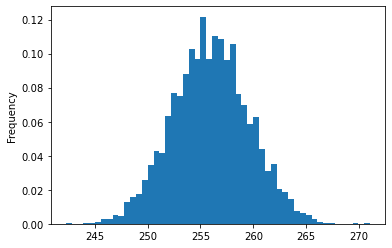

In [21]:
pd.Series(b_strapped).plot(kind="hist", bins="fd", density=True);

#### Exercise 4: bootstrapping to obtain standard errors  <a id="bootstrap_se"></a>

**Ex**: What is the standard deviation of your bootstrap samples of the mean? 

In [22]:
b_strapped.std()

3.624776715656842

**Ex**: Now use `bootstrap_sample` in the same way to generate `5_000` bootstrap samples from `sample` in order to estimate the sampling distribution of `np.median(sample)` and `trimmed_mean(sample)`. What are the standard deviations of these samples, and how do they compare to the estimates and true values (obtained via repeated sampling from `df['duration']`) that you observed earlier?

In [23]:
bootstrapped_stds = {
    statistic.__name__: bootstrap_replicates(statistic, sample, 10_000).std()
    for statistic in statistics
}

In [25]:
for statistic in [np.mean, trimmed_mean, np.median]:
    name = statistic.__name__
    print(
        f"for {name} true std: {true_stds[name]:.2f}, bootstrap std estimate: {bootstrapped_stds[name]:.2f}"
    )

for mean true std: 3.69, bootstrap std estimate: 3.64
for trimmed_mean true std: 3.04, bootstrap std estimate: 3.07
for median true std: 2.68, bootstrap std estimate: 2.66


# 4. Parametric bootstrapping <a id="4"></a>

#### Exercise 5 [optional]: parametric bootstrapping <a id="parametric_bootstrapping"></a>

* An alternative approach that we haven't explored here is to fit a parametric distribution to our data, and to then draw many samples from this fitted distribution in order to estimate the sampling distribution of statistics of interest. A downside here is that you have to have an idea of a reasonable parametric distribution to fit!

* A reasonable choice for `df['duration']` might be a lognormal distribution.

**Ex**: Fit a lognormal distribution to `sample` via maximum likelihood estimation, and use this to compute parametric bootstrap estimates for the statistics that we've considered so far. How do the results compare to your work above?

In [26]:
logged_data = np.log(sample[sample > 0])
mu, sigma = logged_data.mean(), logged_data.std()
lognormal_approx = lognorm(s=sigma, scale=np.exp(mu), loc=0)

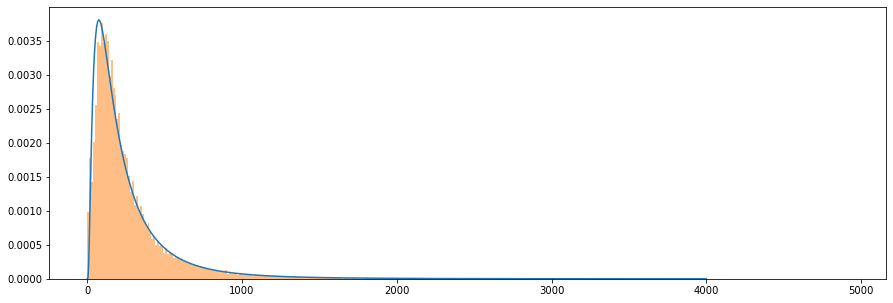

In [27]:
domain = np.arange(0, 4000, step=0.2)
plt.figure(figsize=(15, 5))
plt.plot(domain, lognormal_approx.pdf(domain))
_ = plt.hist(df["duration"], bins="fd", alpha=0.5, density=True)

In [28]:
lognorm_replicates = [lognormal_approx.rvs(5_000) for _ in range(10_000)]

In [29]:
mean_std = np.std([s.mean() for s in lognorm_replicates])
median_std = np.std([np.median(s) for s in lognorm_replicates])
trimmed_mean_std = np.std([trimmed_mean(s) for s in lognorm_replicates])

In [30]:
print(
    "Standard error estimates for "
    f"the mean: {mean_std:.2f}, "
    f"the median: {median_std:.2f}, "
    f"the trimmed mean: {trimmed_mean_std:.2f}"
)

Standard error estimates for the mean: 4.35, the median: 2.85, the trimmed mean: 3.21


# 5. Classical approach <a id="5"></a>

We can also see how/if results from asymptotic theory can help us obtain information about the sampling distribution of our 3 statistics of interest.

### 5.1 Estimate call duration <a id="5.1"></a>

#### Exercise 6: estimate call duration <a id="calc_stats"></a>

**Ex**: What are the mean, median and trimmed mean of `sample`?

In [32]:
print(f"mean: {sample.mean():.2f}, median: {np.median(sample):.2f}")

mean: 255.98, median: 176.50


In [33]:
print(f"trimmed mean: {trimmed_mean(sample):.2f}")

trimmed mean: 224.11


### 5.2 Standard errors  <a id="5.2"></a>

Asymptotic theory would advise us that the sampling distribution of the mean here is well approximated by:

$$\overline{X} \sim \mathcal{N}\big(\mu, \frac{\sigma^2}{N}\big),$$ 

where $\mu$ and $\sigma$ are the mean and standard deviation of the true population, here `df['duration']`. We can construct a 95% confidence interval for $\mu$ according to the formula:

$$[\overline{x} -1.96\frac{\sigma}{\sqrt{N}},\overline{x} +1.96\frac{\sigma}{\sqrt{N}}].$$

#### Exercise 7: standard deviation of the sampling distribution of the mean <a id="mean_se"></a>

**Ex**: How well does the asymptotic estimate $\overline{\sigma}/\sqrt{N}$ for the standard deviation of the sampling distribution of the mean compare to the true standard deviation in this case? You can estimate the latter by drawing repeated samples of size `5_000` from `df['duration']` and computing the standard deviaton of these.

In [34]:
# asymptotic estimate:
asymptotic_std = sample.std() / np.sqrt(len(sample))
print(f"{asymptotic_std:.2f}")

3.63


In [ ]:
print(
    f"{repeated_samples(df['duration'], n_samples=10_000, sample_size=5_000, statistic=np.mean).std():.2f}"
)

* The Central Limit Theorem is very well known, but can only help us estimate the sampling distribution of the mean (although it turns out that asymptotic formulas [do exist](https://stats.stackexchange.com/a/86725) for statistics like the median - they just have parameters which are harder to compute).

#### Exercise 8: computational estimates of standard error for median and trimmed mean <a id="tr_mean_med_se"></a>

3. What are the standard error of the median and trimmed mean of `sample` in our case? 
* As with the mean, you can estimate these by drawing repeated samples of size `5_000` from `df['duration']`. Would it have been a good idea to use $\overline{\sigma}/\sqrt{N}$ as an estimate for these, effectively assuming that they had the same asymptotic distribution as the mean?

In [ ]:
# So whilst asymptotic_std gives an estimate with a relative error of ~1% fo the mean,
# the relative error is closer to 20% and 33% for the trimmed mean and median!

#### Exercise 9: alternative approach for standard error of trimmed mean <a id="trim_mean_se"></a>

**Ex**: A more considered approach to estimating the standard error of the trimmed mean might be to use the formula $\sigma_{\text{trimmed}}/\sqrt{N}$, where $\sigma_{\text{trimmed}}$ is the standard deviation of the middle 90 percent of our sample. How closely does this match the true standard error?

In [ ]:
low, high = np.percentile(sample, [5, 95])
middle = np.array([t for t in sample if t >= low and t <= high])
print(
    f"truncated modification to asymptotic formula for std of trimmed_mean:{middle.std() / np.sqrt(len(middle)):.2f}"
    f" true value: {true_stds['trimmed_mean']:.2f}"
)

In [ ]:
# So this estimate now underestimates dramatically instead.

### Exercise 10 [optional] : asymptotic formula for standard error of median <a id="asym_median"></a>

**Come back and do this if you finish early and get bored**

* Given that an asymptotic formula for the sampling distribution of the median does exist and the CLT does so well when it comes to approximating the sampling distribution of the mean, it's natural to think that we should use asymptotic theory to estimate the standard error of the median as well. 
* We just need to approximate the formula $1/(2f(m))$ where $f$ is the density function of our underlying distribution and $m$ is the median of `df['duration']`.


**Ex**: Estimate $m$ with the median of `sample` and use a kernel density estimate of `sample` to approximate $f$- how well does this perform?

In [ ]:
# this actually performs very well!
from scipy.stats import gaussian_kde

m = np.median(sample)
pdf = gaussian_kde(sample)
std_estimate = (1 / (2 * pdf(m)[0])) / np.sqrt(len(sample))

print(
    f"asymptotic estimate: {std_estimate:.2f}, "
    f"true value: {true_stds['median']:.2f}"
)

### 5.3 Thoughts on asymptotics <a id="5.3"></a>

* We definitely shouldn't use the asymptotic formula for the standard error of the mean to estimate the standard error of the median or trimmed median.
* Asymptotic formulae can work well if we know the right formula for each statistic. These can be very esoteric, however, and you have to either know or be able to compute the right formula in order to use it. What asymptotic formula should we use for the trimmed mean?
* Given that the use classical or asymptotic techniques and estimates is impractical for the median and trimmed mean (which are the statistics which would actually be useful for us here, given their resistance to outliers), it seems that we're in trouble. How can we use these statistics if we're unable to estimate their accuracy?
* Unsurprisingly, the answer that we'll explore here is the bootstrap.